## CIFAR-10 Recipe
In this notebook, we will show how to train a state-of-art CIFAR-10 network with MXNet and extract feature from the network. This example wiil cover

- Network/Data definition
- Multi GPU training
- Model saving and loading
- Prediction/Extracting Feature


In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [4]:

import mxnet as mx
import logging
import numpy as np

# setup logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# First, let's make some helper function to let us build 
# a simplified Inception Network. More details about how 
# to composite symbol into component can be found at composite_symbol

# Basic Conv + BN + ReLU factory
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), act_type="relu"):
    # there is an optional parameter ```wrokshpace``` may influece convolution performance
    # default, the workspace is set to 256(MB)
    # you may set larger value, but convolution layer only requires its needed but not exactly
    # MXNet will handle reuse of workspace without parallelism conflict
    conv = mx.symbol.Convolution(data=data, workspace=256,
                                 num_filter=num_filter, kernel=kernel, stride=stride, pad=pad)
    bn = mx.symbol.BatchNorm(data=conv)
    act = mx.symbol.Activation(data = bn, act_type=act_type)
    return act
  
  
# A Simple Downsampling Factory
def DownsampleFactory(data, ch_3x3):
    # conv 3x3
    conv = ConvFactory(data=data, kernel=(3, 3), stride=(2, 2), num_filter=ch_3x3, pad=(1, 1))
    # pool
    pool = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(2, 2), pad=(1,1), pool_type='max')
    # concat
    concat = mx.symbol.Concat(*[conv, pool])
    return concat

  
# A Simple module
def SimpleFactory(data, ch_1x1, ch_3x3):
    # 1x1
    conv1x1 = ConvFactory(data=data, kernel=(1, 1), pad=(0, 0), num_filter=ch_1x1)
    # 3x3
    conv3x3 = ConvFactory(data=data, kernel=(3, 3), pad=(1, 1), num_filter=ch_3x3)
    #concat
    concat = mx.symbol.Concat(*[conv1x1, conv3x3])
    return concat

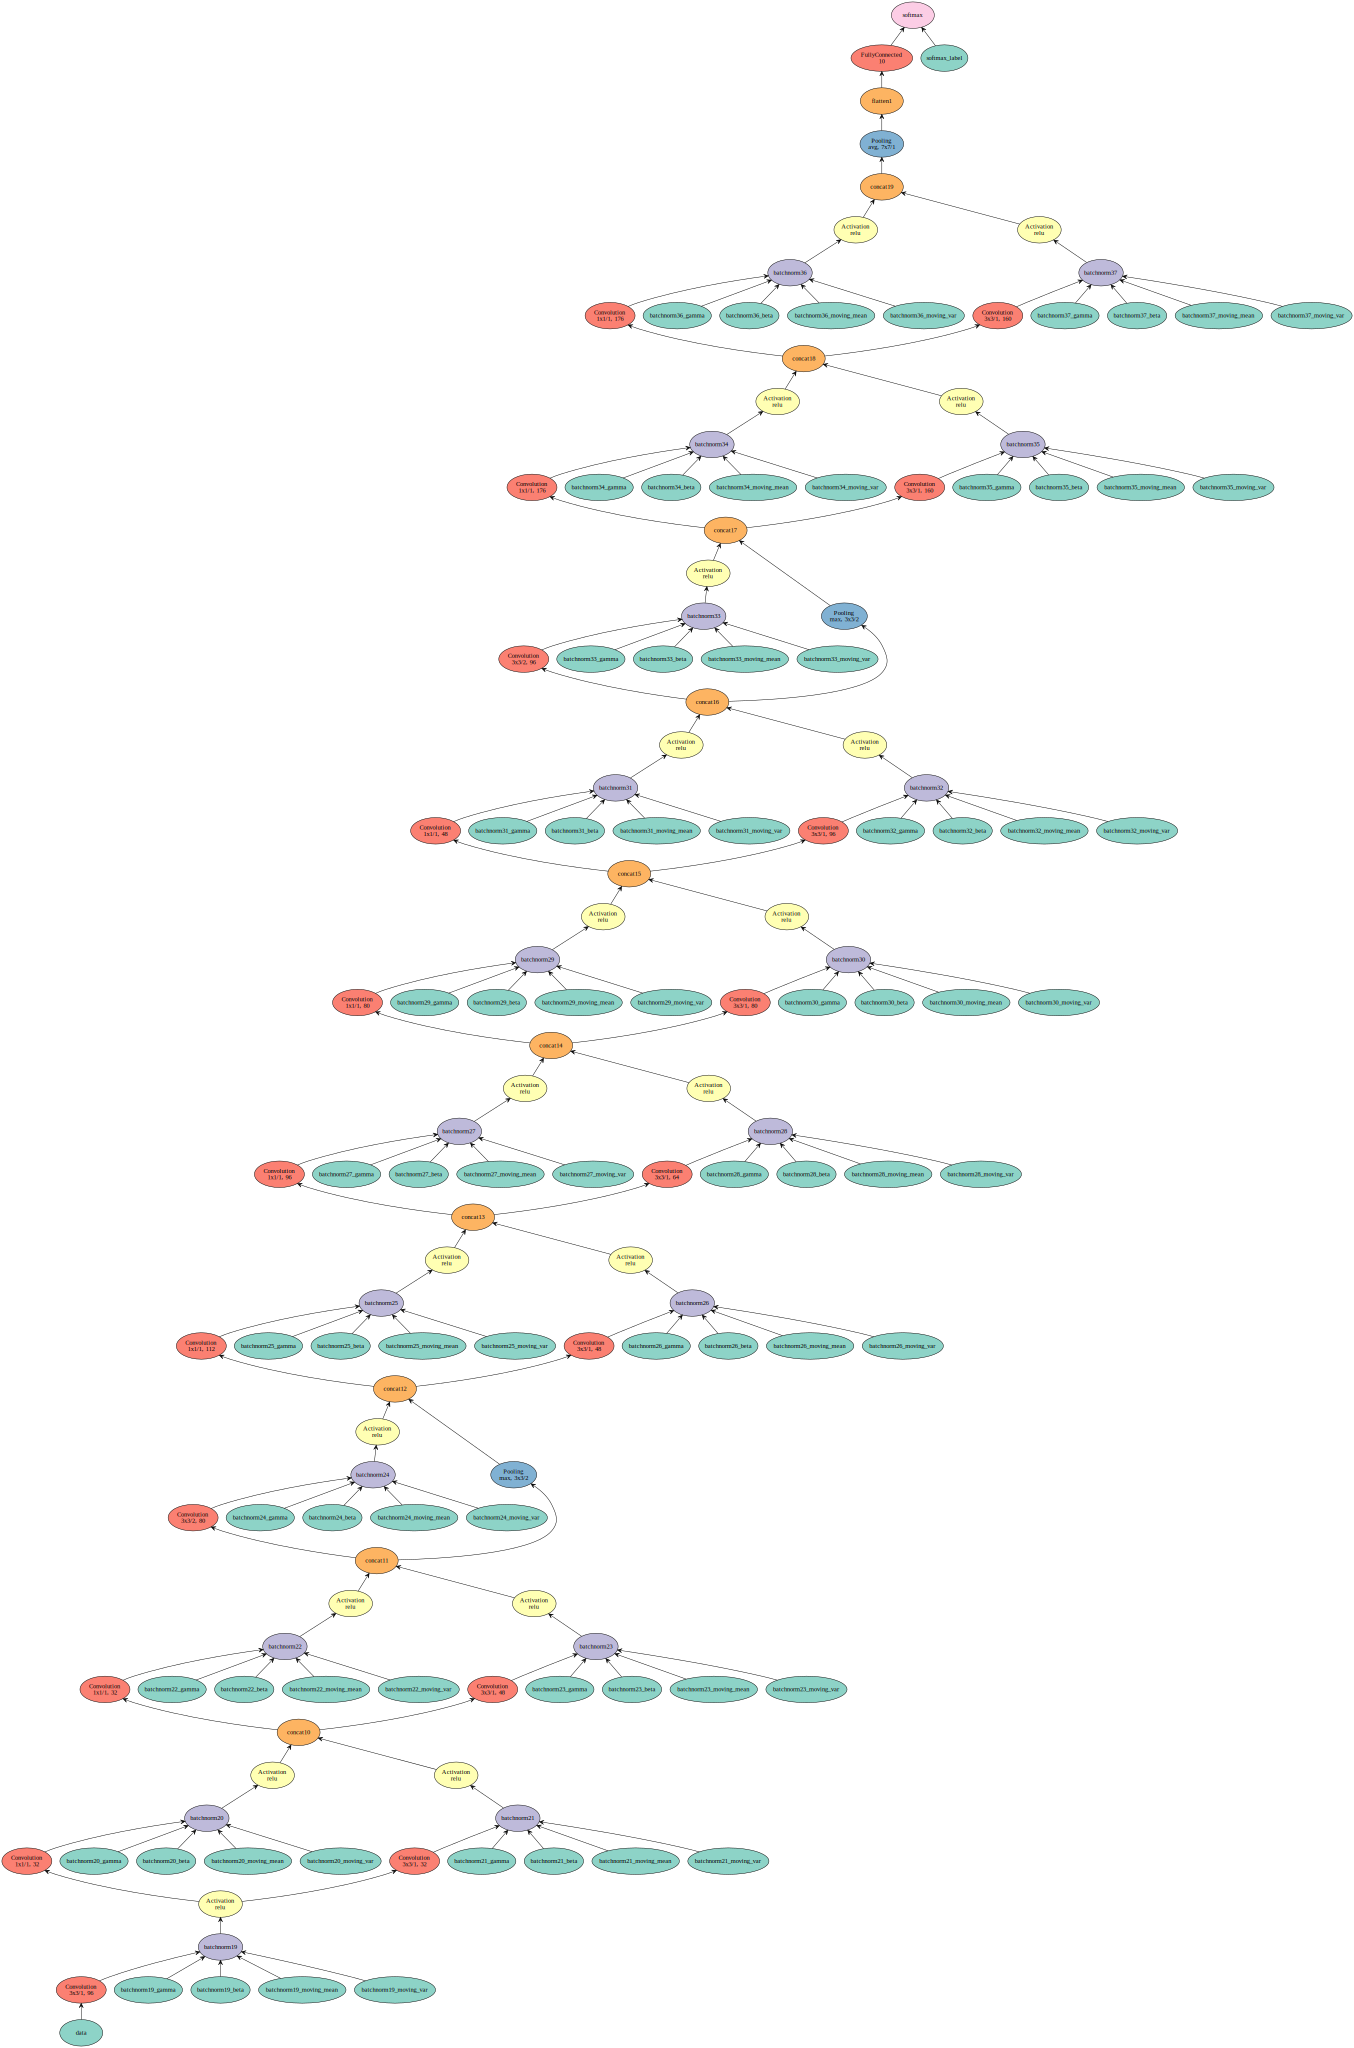

In [7]:
# Now we can build a network with these component factories

data = mx.symbol.Variable(name="data")
conv1 = ConvFactory(data=data, kernel=(3,3), pad=(1,1), num_filter=96, act_type="relu")
in3a = SimpleFactory(conv1, 32, 32)
in3b = SimpleFactory(in3a, 32, 48)
in3c = DownsampleFactory(in3b, 80)
in4a = SimpleFactory(in3c, 112, 48)
in4b = SimpleFactory(in4a, 96, 64)
in4c = SimpleFactory(in4b, 80, 80)
in4d = SimpleFactory(in4c, 48, 96)
in4e = DownsampleFactory(in4d, 96)
in5a = SimpleFactory(in4e, 176, 160)
in5b = SimpleFactory(in5a, 176, 160)
pool = mx.symbol.Pooling(data=in5b, pool_type="avg", kernel=(7,7), name="global_avg")
flatten = mx.symbol.Flatten(data=pool)
fc = mx.symbol.FullyConnected(data=flatten, num_hidden=10)
softmax = mx.symbol.SoftmaxOutput(name='softmax',data=fc)

# If you'd like to see the network structure, run the plot_network function
mx.viz.plot_network(symbol=softmax,
                    node_attrs={'shape':'oval','fixedsize':'false'}
                   )

In [8]:
# We will make model with current current symbol
# For demo purpose, this model only train 1 epoch
# We will use the first GPU to do training
num_epoch = 1
model = mx.model.FeedForward(ctx=mx.cpu(),
                             symbol=softmax,
                             num_epoch=num_epoch,
                             learning_rate=0.05,
                             momentum=0.9,
                             wd=0.00001
                            )

# we can add learning rate scheduler to the model
# model = mx.model.FeedForward(ctx=mx.cpu(), symbol=softmax, num_epoch=num_epoch,
#                              learning_rate=0.05, momentum=0.9, wd=0.00001,
#                              lr_scheduler=mx.misc.FactorScheduler(2))
# In this example. learning rate will be reduced to 0.1 * previous learning rate for every 2 epochs

/Users/probe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [ ]:
# Use utility function in test to download the data
# or manualy prepar


def GetCifar10():
    if not os.path.isdir("data/"):
        os.system("mkdir data/")
    if (not os.path.exists('data/cifar/train.rec')) or \
       (not os.path.exists('data/cifar/test.rec')) or \
       (not os.path.exists('data/cifar/train.lst')) or \
       (not os.path.exists('data/cifar/test.lst')):
        os.system("wget http://data.mxnet.io/mxnet/data/cifar10.zip -P data/")
        os.chdir("./data")
        os.system("unzip -u cifar10.zip")
        os.chdir("..")


def get_cifar10(data_dir):
    if not os.path.isdir(data_dir):
        os.system("mkdir " + data_dir)
    cwd = os.path.abspath(os.getcwd())
    os.chdir(data_dir)
    if (not os.path.exists('cifar10_train.rec')) or \
       (not os.path.exists('cifar10_test.rec')) :
        import urllib, zipfile, glob
        dirname = os.getcwd()
        zippath = os.path.join(dirname, "cifar10.zip")
        urllib.urlretrieve("http://data.mxnet.io/mxnet/data/cifar10.zip", zippath)
        zf = zipfile.ZipFile(zippath, "r")
        zf.extractall()
        zf.close()
        os.remove(zippath)
        for f in glob.glob(os.path.join(dirname, "cifar", "*")):
            name = f.split(os.path.sep)[-1]
            os.rename(f, os.path.join(dirname, name))
        os.rmdir(os.path.join(dirname, "cifar"))
    os.chdir(cwd)

# data
def get_cifar10_iterator(args, kv):
    data_shape = (3, 28, 28)
    data_dir = args.data_dir
    if os.name == "nt":
        data_dir = data_dir[:-1] + "\\"
    if '://' not in args.data_dir:
        get_cifar10(data_dir)

    train = mx.io.ImageRecordIter(
        path_imgrec = os.path.join(data_dir, "train.rec"),
        mean_img    = os.path.join(data_dir, "mean.bin"),
        data_shape  = data_shape,
        batch_size  = args.batch_size,
        rand_crop   = True,
        rand_mirror = True,
        num_parts   = kv.num_workers,
        part_index  = kv.rank)

    val = mx.io.ImageRecordIter(
        path_imgrec = os.path.join(data_dir, "test.rec"),
        mean_img    = os.path.join(data_dir, "mean.bin"),
        rand_crop   = False,
        rand_mirror = False,
        data_shape  = data_shape,
        batch_size  = args.batch_size,
        num_parts   = kv.num_workers,
        part_index  = kv.rank)

    return (train, val)

In [11]:
# Next step is declaring data iterator. 
# The original CIFAR-10 data is 3x32x32 
# in binary format, we provides RecordIO format, 
# so we can use Image RecordIO format. 
# For more infomation about Image RecordIO Iterator, 
# check document.

import sys
# get_data.GetCifar10()
# After we get the data, we can declare our data iterator
# The iterator will automatically create mean image file 
# if it doesn't exist
batch_size = 128
total_batch = 50000 / 128 + 1
# Train iterator make batch of 128 image, and random 
# crop each image into 3x28x28 from original 3x32x32
train_dataiter = mx.io.ImageRecordIter(
        shuffle=True,
        path_imgrec="cifar10_train.rec",
        mean_img="cifar10_train_mean.bin",
        rand_crop=True,
        rand_mirror=True,
        data_shape=(3,28,28),
        batch_size=batch_size,
        preprocess_threads=1)
# test iterator make batch of 128 image, and center crop each image into 3x28x28 from original 3x32x32
# Note: We don't need round batch in test because we only test once at one time
test_dataiter = mx.io.ImageRecordIter(
        path_imgrec="cifar10_val.rec",
        mean_img="cifar10_val_mean.bin",
        rand_crop=False,
        rand_mirror=False,
        data_shape=(3,28,28),
        batch_size=batch_size,
        round_batch=False,
        preprocess_threads=1)

In [ ]:
# Now we can fit the model with data.

model.fit(X=train_dataiter,
          eval_data=test_dataiter,
          eval_metric="accuracy",
          batch_end_callback=mx.callback.Speedometer(batch_size))

# if we want to save model after every epoch, we can add check_point call back
# model_prefix = './cifar_'
# model.fit(X=train_dataiter,
#           eval_data=test_dataiter,
#           eval_metric="accuracy",
#           batch_end_callback=mx.helper.Speedometer(batch_size),
#           epoch_end_callback=mx.callback.do_checkpoint(model_prefix))

/Users/probe/anaconda/lib/python3.5/site-packages/mxnet-0.9.4-py3.5-macosx-10.6-x86_64.egg/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
/Users/probe/anaconda/lib/python3.5/site-packages/mxnet-0.9.4-py3.5-macosx-10.6-x86_64.egg/mxnet/model.py:522: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]


After only 1 epoch, our model is able to acheive about 65% accuracy on testset(If not, try more times). We can save our model by calling either save or using pickle.

In [ ]:
# using pickle
import pickle
smodel = pickle.dumps(model)
# using saving (recommended)
# We get the benefit being able to 
# directly load/save from cloud storage(S3, HDFS)
prefix = "cifar10"
model.save(prefix)

In [ ]:
# To load saved model, you can use pickle if the model 
# is generated by pickle, or use load if it is generated by save

# use pickle
model2 = pickle.loads(smodel)
# using load method (able to load from S3/HDFS directly)
model3 = mx.model.FeedForward.load(prefix, num_epoch, ctx=mx.gpu())

In [ ]:
# We can use the model to do prediction

prob = model3.predict(test_dataiter)
logging.info('Finish predict...')
# Check the accuracy from prediction
test_dataiter.reset()
# get label
# Because the iterator pad each batch same shape, we want to remove paded samples here

y_batch = []
for dbatch in test_dataiter:
    label = dbatch.label[0].asnumpy()
    pad = test_dataiter.getpad()
    real_size = label.shape[0] - pad
    y_batch.append(label[0:real_size])
y = np.concatenate(y_batch)

# get prediction label from 
py = np.argmax(prob, axis=1)
acc1 = float(np.sum(py == y)) / len(y)
logging.info('final accuracy = %f', acc1)